In [1]:
import os, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import KDTree, QhullError
from scipy.stats import truncnorm
from scipy.interpolate import LinearNDInterpolator, griddata

In [2]:
import numpyro
from numpyro.handlers import seed, substitute, trace
from jax import random
from celestify.numpyro_models import HierarchicalStarModel

2024-02-05 15:24:36.673484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 15:24:36.673512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 15:24:36.674484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 15:24:37.243170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [3]:
num_stars = 100000
rng = random.PRNGKey(0)

true_model = HierarchicalStarModel(num_stars)

truths = {
    "mu_a": 2.0,
    "sigma_a": 0.05,
    "Y_0": 0.247,
    "dY_dZ": 1.5,
    "sigma_Y": 0.005,
}

rng, key = random.split(rng)
true_trace = trace(seed(substitute(true_model, truths), key)).get_trace()
truths.update({k: np.array(v["value"]) for k, v in true_trace.items()})

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-02-05 15:24:38.216619: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Save the truths as a json file.

In [4]:
directory = "/mnt/data-storage/alexlyttle/scalable-stellar-inference"

with open(os.path.join(directory, "truths.json"), "w") as file:
    file.write(json.dumps({k: v.tolist() for k, v in truths.items()}))

In [5]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/dataset.h5"
train = pd.read_hdf(filename, "train").reset_index()
train.head()

,index,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,...,log_g,log_L,delta_X,f_nuc,phase,EEP,bol_mag,abs_G,abs_BP,abs_RP
0,4239372,1084,272,1.19292,0.268233,0.007538,2.488300,0.000000,0.006041,4.203466e+09,...,3.719144,0.776902,0.724229,1.013812,0,0.271755,2.807746,2.743953,3.060732,2.259917
1,4364990,1240,59,0.91167,0.244405,0.001755,1.542206,0.000000,0.006041,3.569699e+09,...,4.411202,0.123200,0.367104,0.999825,0,0.083324,4.442001,4.425188,4.661513,4.021369
2,3633770,5326,429,1.66118,0.260537,0.006578,1.536823,0.011188,0.006041,1.381822e+09,...,3.935007,1.332668,0.732880,1.072159,0,0.229643,1.418331,1.409047,1.471893,1.292427
3,5992731,4261,777,2.13472,0.227242,0.022099,1.757880,0.015893,0.006041,1.389514e+09,...,3.262804,1.199392,0.750659,1.074809,0,0.513249,1.751521,1.802734,2.306055,1.153757
4,3832114,5574,553,1.75181,0.282216,0.004477,2.507526,0.012875,0.006041,9.558198e+08,...,3.757938,1.566193,0.713306,1.008049,0,0.256022,0.834517,0.844560,0.894313,0.753581


In [6]:
test = pd.read_hdf(filename, "test").sample(frac=1).reset_index()
test.head()

,index,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,...,log_g,log_L,delta_X,f_nuc,phase,EEP,bol_mag,abs_G,abs_BP,abs_RP
0,1479572,838,405,1.77261,0.229854,0.006691,2.645526,0.013196,0.006041,1.316083e+09,...,3.841631,1.391340,0.763455,1.004048,0,0.212478,1.271651,1.237961,1.321091,1.084415
1,2302257,3861,681,2.23628,0.294918,0.010733,1.781122,0.016107,0.006041,6.347559e+08,...,3.592209,1.883737,0.694349,1.040891,0,0.328070,0.040659,0.051750,0.086526,-0.009145
2,3776895,5503,594,0.76431,0.281435,0.021500,1.621588,0.000000,0.006041,3.687810e+10,...,2.366217,1.361340,0.697065,0.995783,0,0.937906,1.346649,1.737803,2.491736,0.911312
3,6088416,4381,830,1.93159,0.236031,0.014426,1.798895,0.014927,0.006041,1.431623e+09,...,3.384333,1.112194,0.749543,1.115601,0,0.469410,1.969515,1.972112,2.416627,1.370634
4,5139154,6200,420,0.99165,0.287734,0.004511,1.414459,0.000000,0.006041,6.487178e+09,...,2.961054,1.103148,0.707756,0.995606,0,0.637291,1.992131,2.112386,2.632660,1.445153


In [7]:
input_cols = ["EEP", "star_mass", "M_H", "Yinit", "amlt"]
output_cols = ["star_age", "Teff", "radius", "Dnu_freq_o"]

In [27]:
# loc = train[input_cols].mean(0).to_numpy()
# scale = train[input_cols].std(0).to_numpy()

loc = train[input_cols].min(0).to_numpy()
scale = train[input_cols].max(0).to_numpy() - loc
scale[0] *= 1e-2  # make EEP distances larger

tree = KDTree((train[input_cols] - loc) / scale)

In [35]:
num_neigbours = 500
num_test = 1000

test_inputs = test[input_cols].iloc[:num_test].to_numpy()
test_outpus = test[output_cols].iloc[:num_test].to_numpy()

x_scaled = (test_inputs - loc) / scale
distances, indices = tree.query(x_scaled, num_neigbours)

In [36]:
interp_values = np.full((num_test, len(output_cols)), np.nan)
train_inputs = train[input_cols].to_numpy()
train_outputs = train[output_cols].to_numpy()

In [37]:
for i, index in enumerate(indices):
    try:
        interp_values[i] = griddata(train_inputs[index], train_outputs[index], test_inputs[i])
    except QhullError:
        continue

In [38]:
np.isnan(interp_values).all(1).sum()

7

In [39]:
interp_outpus = pd.DataFrame(interp_values, columns=output_cols)
test_error = test_outpus - interp_outpus

In [40]:
test_error.describe()

,star_age,Teff,radius,Dnu_freq_o
count,9.930000e+02,993.000000,993.000000,993.000000
mean,-3.935019e+07,-0.285420,0.003999,-0.012917
std,2.146783e+08,9.041677,0.118152,0.214516
min,-3.989179e+09,-195.032861,-1.036358,-4.319659
25%,-2.867097e+03,-0.029712,-0.000035,-0.001008
50%,3.215807e+02,0.004291,-0.000009,-0.000093
75%,8.205776e+03,0.049156,0.000022,0.000406
max,1.156774e+08,70.917358,2.240186,2.219376


In [7]:
model_cols = ["evol", "mass", "M_H", "Y", "a_MLT"]
x = np.stack([truths[k] for k in model_cols], axis=-1)
x_scaled = (x - loc) / scale
dist, i = tree.query(x_scaled)

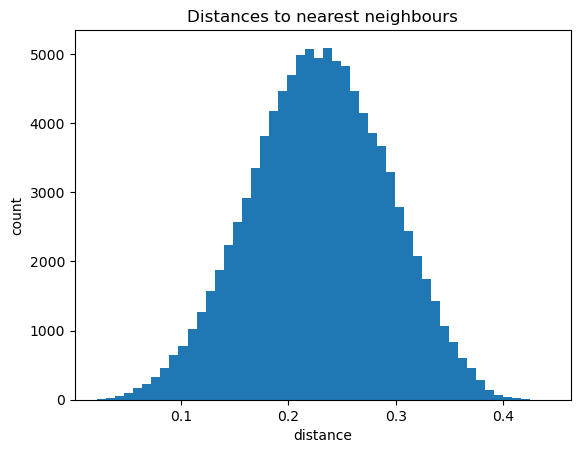

In [8]:
fig, ax = plt.subplots()
ax.hist(dist, bins=50)
ax.set_xlabel("distance")
ax.set_ylabel("count")
ax.set_title("Distances to nearest neighbours");

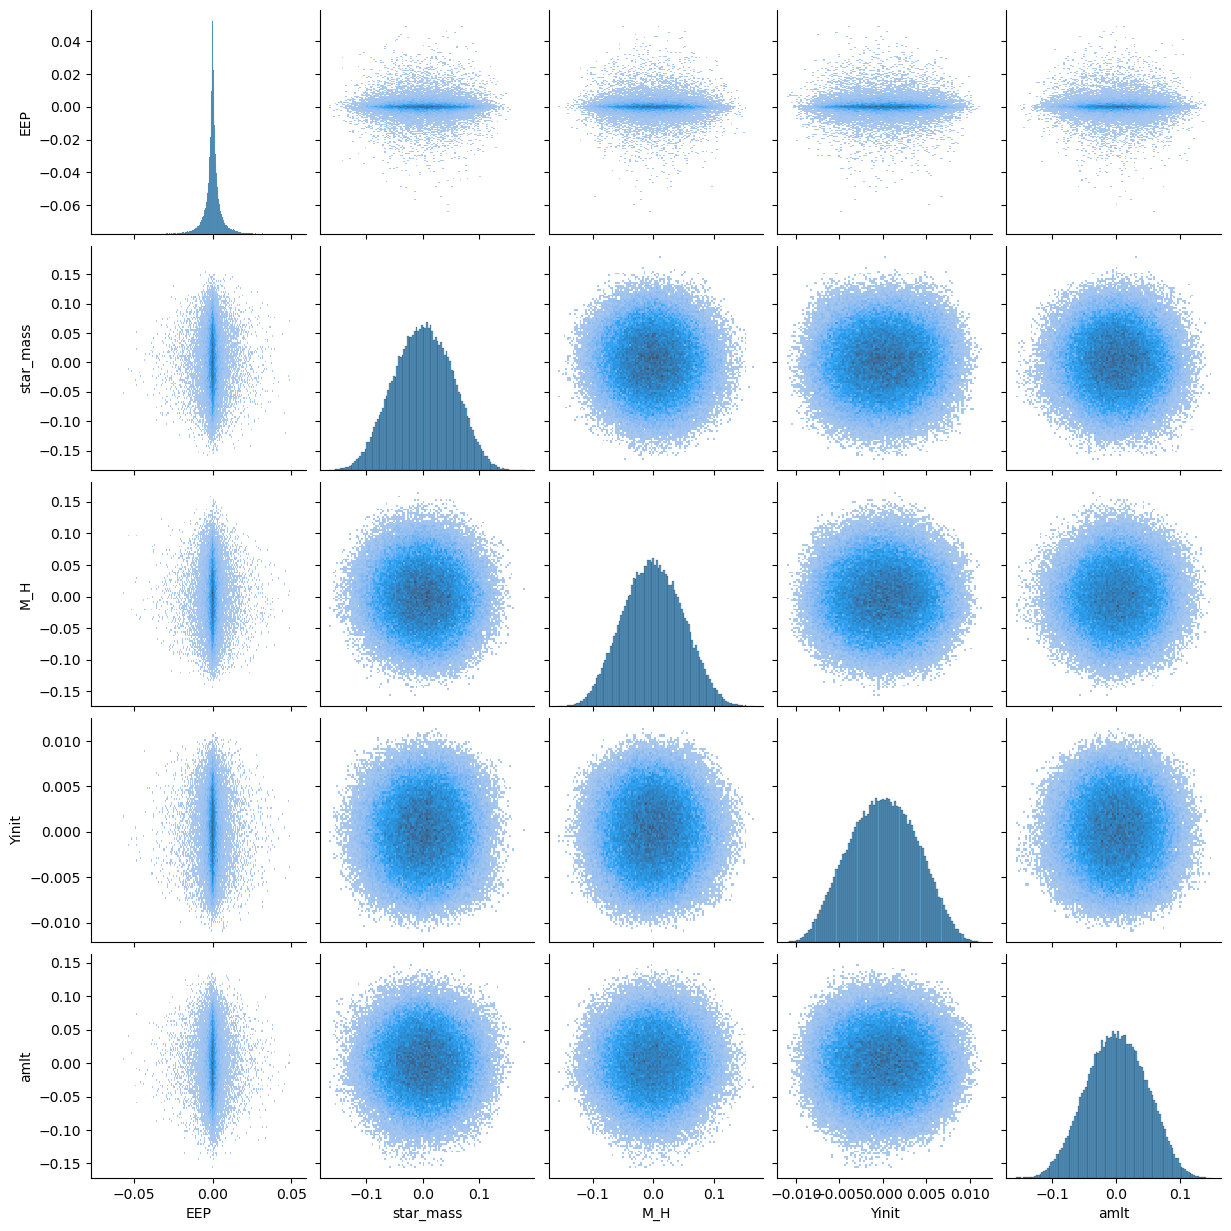

In [9]:
error = test[input_cols].iloc[i] - x
sns.pairplot(error, kind="hist", diag_kind="hist");

In [10]:
q = [.01, .16, .5, .84, .99]
error.quantile(q)

,EEP,star_mass,M_H,Yinit,amlt
0.01,-0.019949,-0.111531,-0.103973,-0.007980,-0.101274
0.16,-0.003369,-0.051956,-0.049954,-0.003983,-0.046556
0.50,-0.000013,0.001295,-0.000569,0.000095,0.000924
0.84,0.003310,0.053940,0.049930,0.004127,0.048619
0.99,0.019238,0.111204,0.106854,0.008192,0.099349


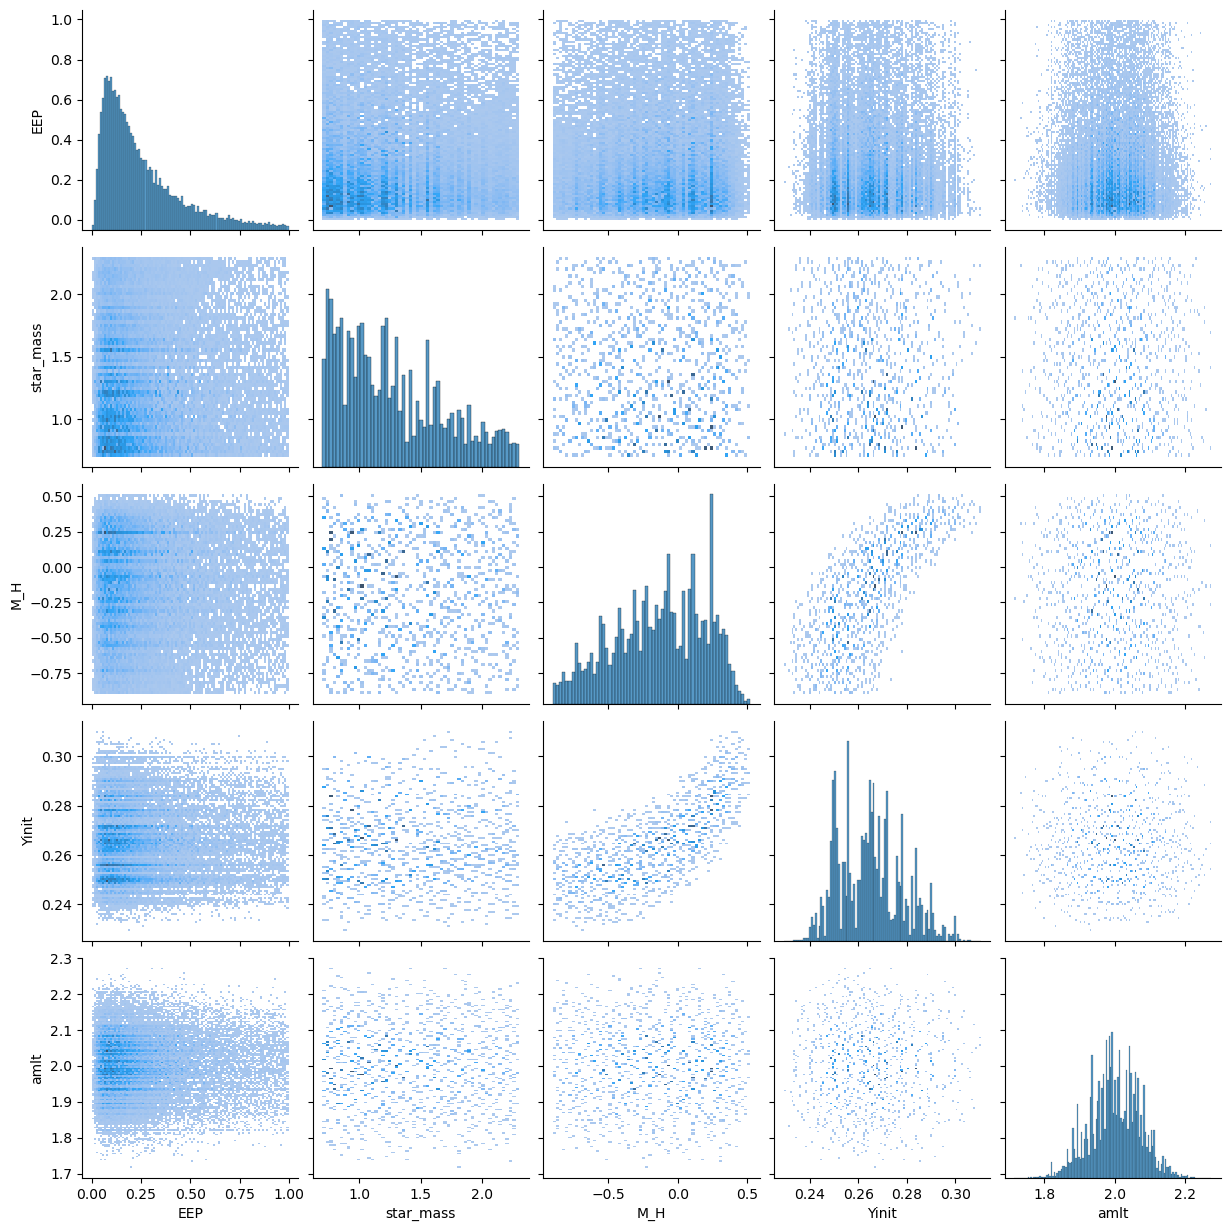

In [11]:
sns.pairplot(test[input_cols].iloc[i], kind="hist", diag_kind="hist");

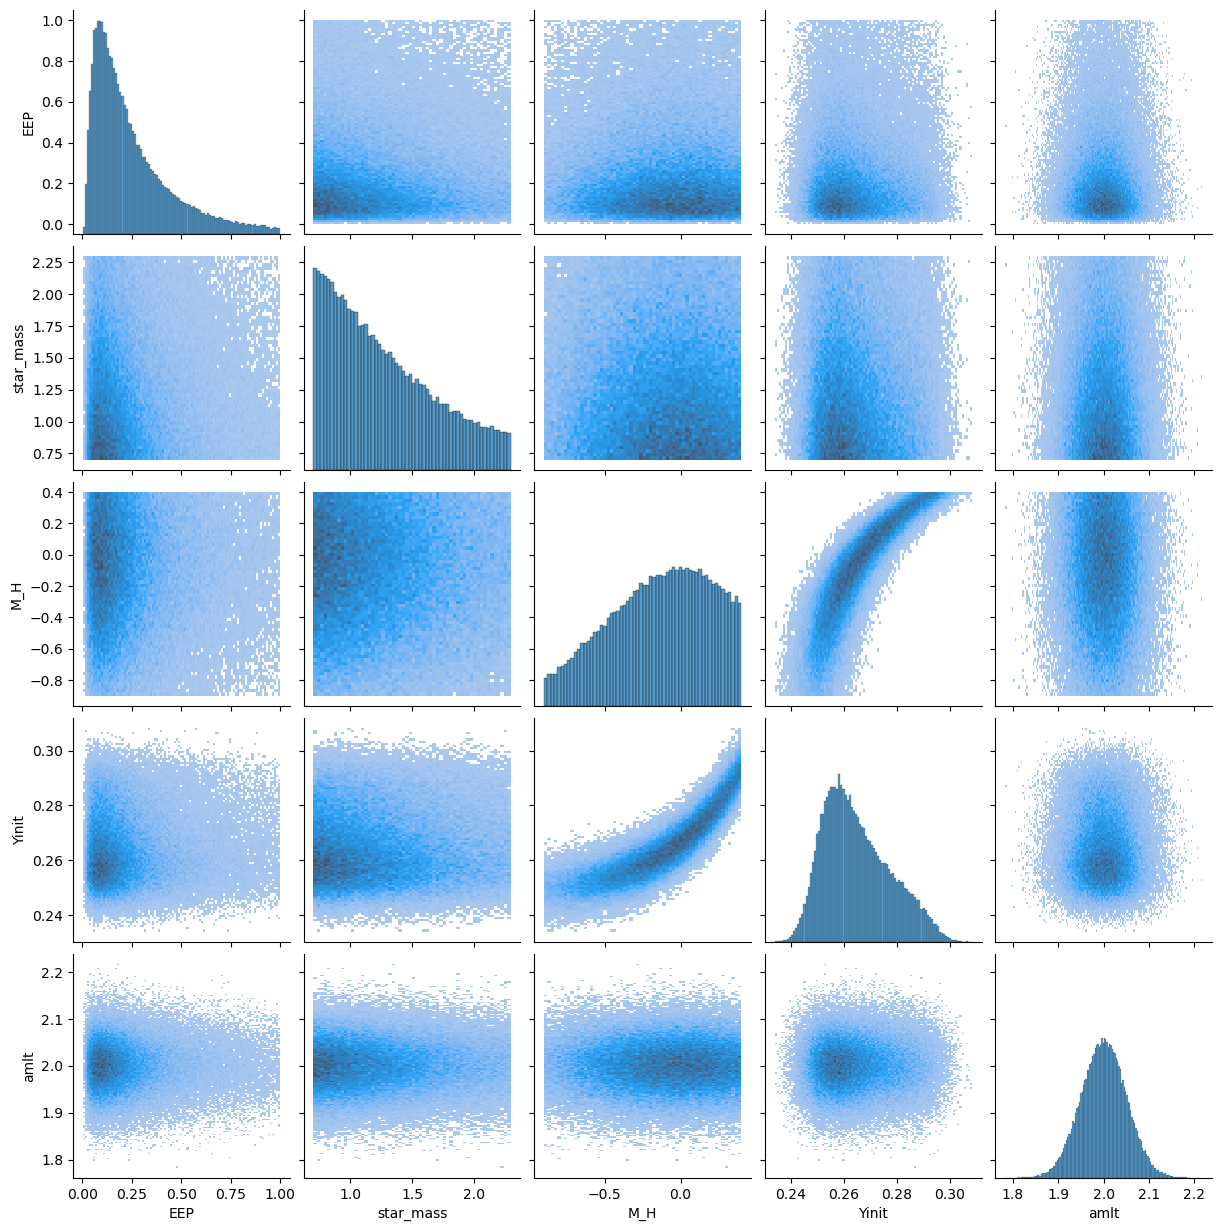

In [12]:
samples = pd.DataFrame(x, columns=input_cols)
sns.pairplot(samples, kind="hist", diag_kind="hist");

Save the nearest neighbour truths.

In [14]:
test.iloc[i].to_csv(os.path.join(directory, "truths-nearest-neighbour.csv"))

Experiment with linear interpolation.

In [26]:
from scipy.interpolate import LinearNDInterpolator
from time import time
from pympler import asizeof

In [15]:
output_cols = ["log_Teff", "log_radius"]

In [74]:
num_train = [10**i for i in range(1, 6)]
build_times = []
eval_times = []
total_time = []
sizes = []

for n in num_train:
    start_time = time()
    interpolator = LinearNDInterpolator(train[input_cols].iloc[:n], train[output_cols].iloc[:n])
    build_time = time() - start_time
    _ = interpolator(test[input_cols].iloc[0])
    eval_time = time() - build_time - start_time
    build_times.append(build_time)
    eval_times.append(eval_time)
    total_time.append(build_time + eval_time)
    sizes.append(asizeof.asizeof(interpolator))

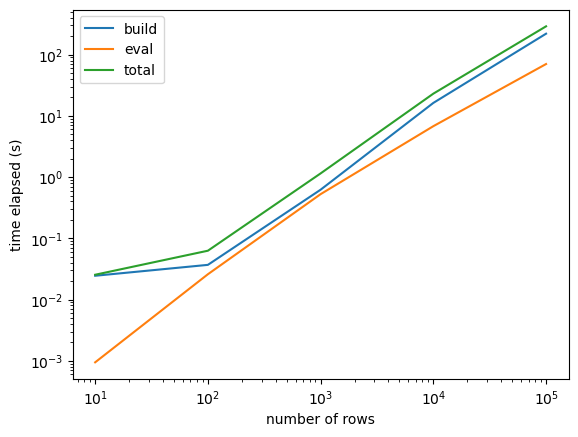

In [76]:
fig, ax = plt.subplots()
ax.plot(num_train, build_times, label="build")
ax.plot(num_train, eval_times, label="eval")
ax.plot(num_train, total_time, label="total")
ax.set_xlabel("number of rows")
ax.set_ylabel("time elapsed (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

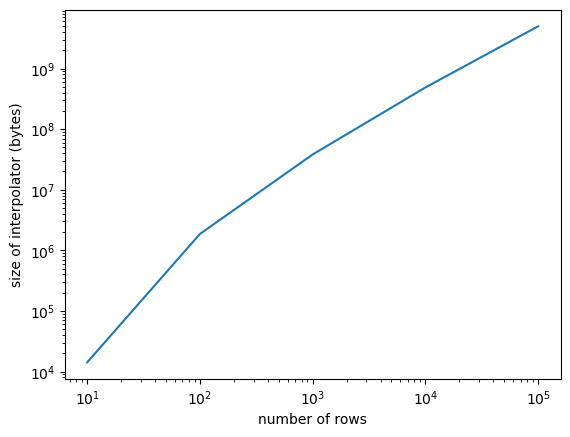

In [79]:
fig, ax = plt.subplots()
ax.plot(num_train, sizes)
ax.set_xlabel("number of rows")
ax.set_ylabel("size of interpolator (bytes)")
ax.set_xscale("log")
ax.set_yscale("log");

In [102]:
log_n = np.log(0.1*train.shape[0])
m = (np.diff(np.log(total_time[1:])) / np.diff(np.log(num_train[1:]))).max()
log_t = m * log_n + np.log(total_time[-1]) - m * np.log(num_train[-1])
print(f"Total time: {np.exp(log_t) / 60 / 60:.2f} hours")


Total time: 0.65 hours


In [103]:
m = (np.diff(np.log(sizes[1:])) / np.diff(np.log(num_train[1:]))).max()
log_s = m * log_n + np.log(sizes[-1]) - m * np.log(num_train[-1])
print(f"Size: {np.exp(log_s)*1e-9:.2f} gigabytes")

Size: 40.79 gigabytes


Experiment with inverse distance weighting for dataset $D = \{(x_i, y_i)\}_{i=1}^N$

$$f(x) = \frac{\sum_{i=1}^N w_i(x) y_i}{\sum_{i=1}^N w_i(x)}$$

where the weights are defined by the distance between $x$ and $x_i$ raised to some power,

$$w_i = d(x, x_i)^{-p}$$

The power should be similar to the number of dimensions in $x$.

The modified Shephard's method computes the weights for points a given radius $R$ around the new point.

$$w_k = \left( \frac{\max(0, R - d(x, x_k))}{R \, d(x, x_k)} \right)^p$$

Franke, R., and Nielson, G. (1980), 'Smooth Interpolation of Large Sets of Scattered Data', International Journal for Numerical Methods in Engineering, v. 15, p. 1691-1704.

In [110]:
k = 1000
dist, indices = tree.query(x_scaled, k)

In [123]:
R = dist[:, -1][:, None]
p = 2
weights = (np.maximum(0.0, R - dist) / R / dist)**p

In [124]:
x_pred = (test[input_cols].to_numpy()[indices] * weights[..., None]).sum(axis=1) / weights.sum(axis=1)[:, None]

In [125]:
err = samples - x_pred

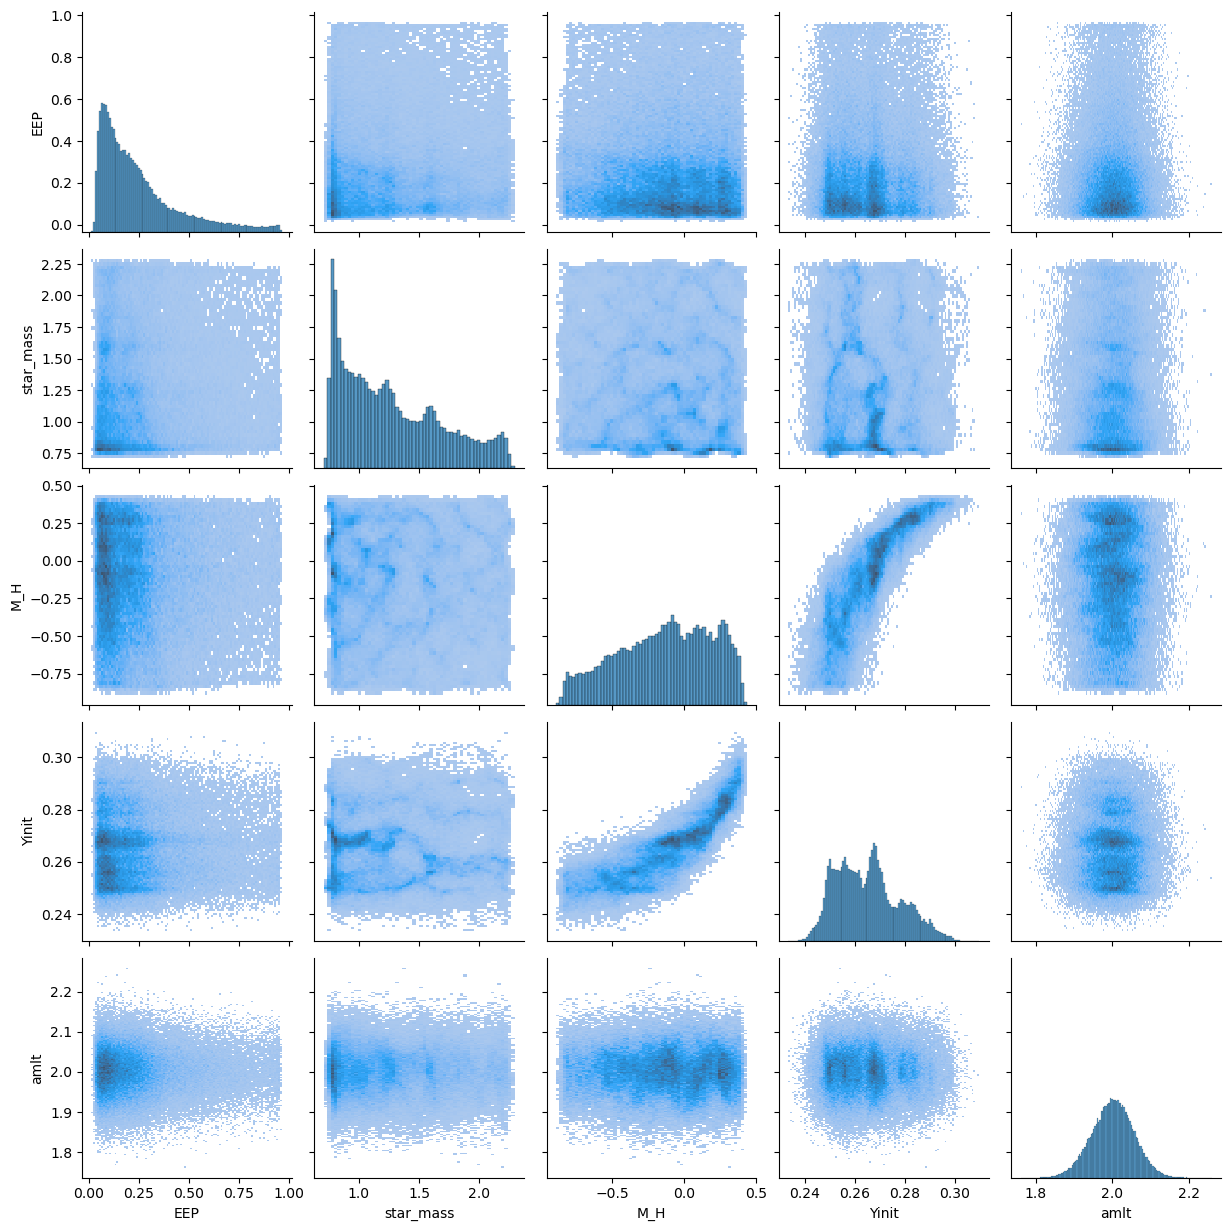

In [126]:
samples_pred = pd.DataFrame(x_pred, columns=input_cols)
sns.pairplot(samples_pred, kind="hist", diag_kind="hist");

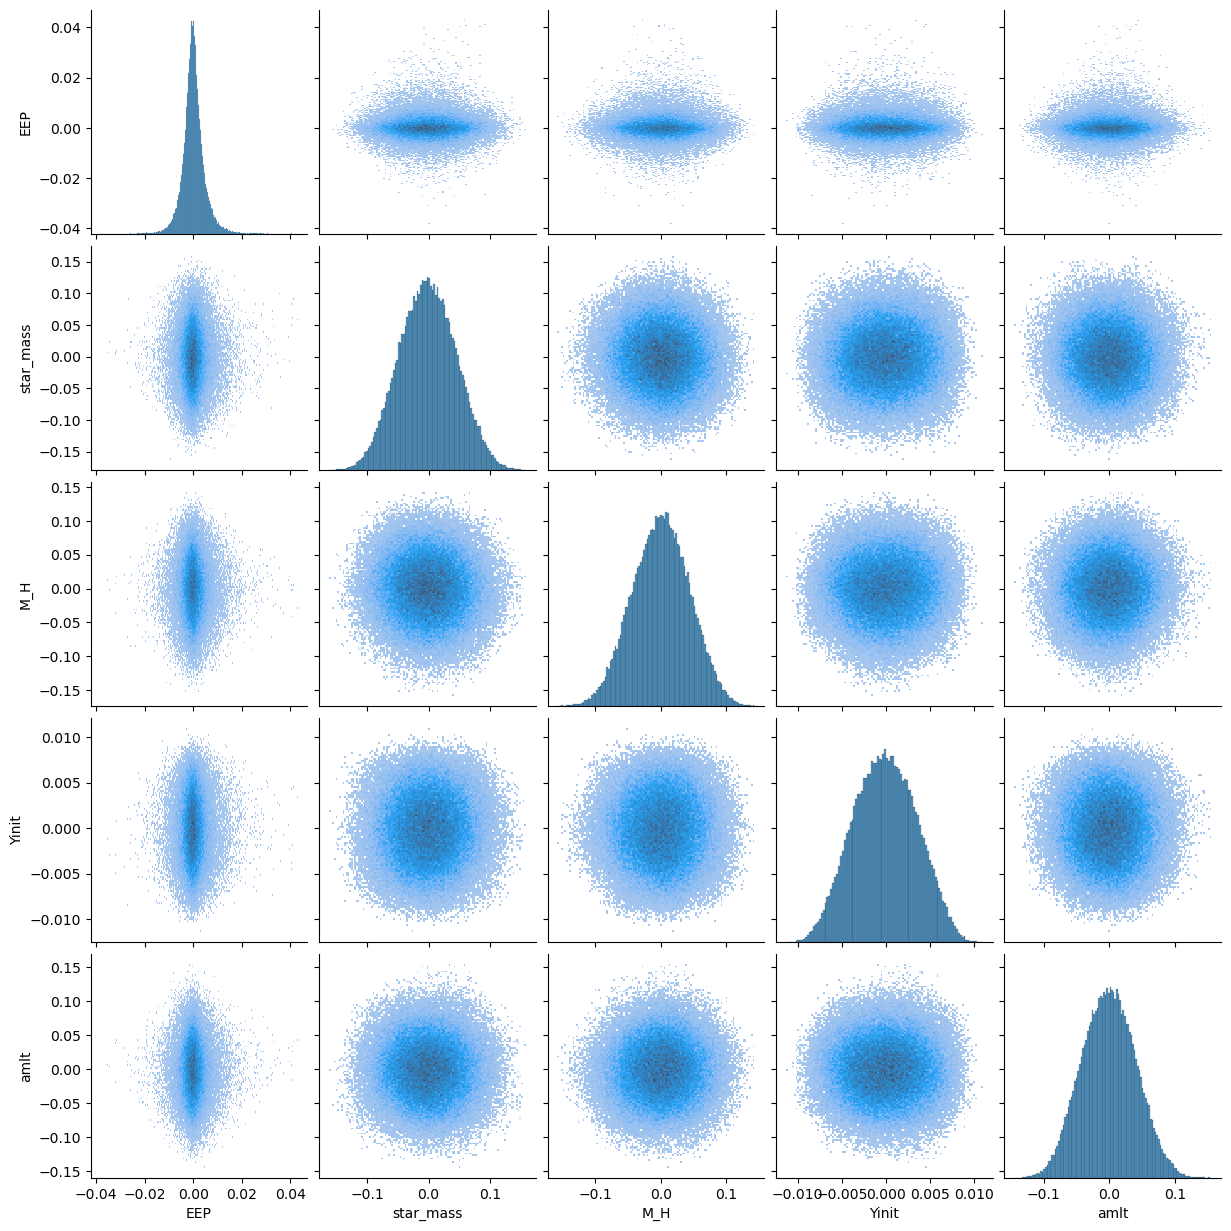

In [104]:
sns.pairplot(err, kind="hist", diag_kind="hist");